In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import numpy as np
import scipy.signal
from scipy.ndimage import gaussian_filter1d

In [3]:
blue = '#3C608A'
lightgray = '#d3d8d6'
darkblue = '#2e4465'
bpc_darkgray = '#333638'
red = '#e43e47'
lightblue = '#3687e7'
mustard = '#D4AD50'
purple = '#5E233B'
pink = '#F87FAB'

In [4]:

# Set up the data directory
data_dir = "data"

def load_verifier_data(data_dir):
    """Load all verifier data files from the data directory."""
    all_data = []
    
    for folder in sorted(os.listdir(data_dir)):
        folder_path = os.path.join(data_dir, folder)
        csv_path = os.path.join(folder_path, "verifier-machines.csv")
        
        if os.path.isfile(csv_path):
            df = pd.read_csv(csv_path, skiprows=1, index_col=False)  # Skip the first two descriptive rows
            df['Year'] = folder.split('_')[0]  # Extract the year from folder name
            all_data.append(df)
    
    return pd.concat(all_data, ignore_index=True)

# Load data
df = load_verifier_data(data_dir)

# Convert columns to appropriate types
df['Year'] = df['Year'].astype(int)
df['First Year in Use'] = df['First Year in Use'].astype('Int64')

# Create a new column to identify new equipment

def is_new_equipment(row):
    return row['First Year in Use'] == row['Year']

df['New Equipment'] = df.apply(is_new_equipment, axis=1)
df['First Year in Use'] = abs(df['First Year in Use']) # some years are negative, make them positive
df['Years in Use'] = df['Year'] - df['First Year in Use']


In [5]:
df[df['First Year in Use'].isna()].sample(10)

,FIPS code,State,Jurisdiction,Equipment Type,Manufacturer,Model,First Year in Use,VVPAT,Election Day Standard,Election Day Accessible,Early Voting Standard,Early Voting Accessible,Mail Ballot/Absentee Equipment,Notes on usage,Year,New Equipment,Years in Use
142674,5507773600,Wisconsin,Town of Shields (Marquette County),Hand Counted Paper Ballots,Not Applicable,Not Applicable,<NA>,NaN,Yes,No,Yes,No,Yes,NaN,2016,<NA>,<NA>
231859,2300343255,Maine,Town of Mapleton (Aroostook County),Paper Poll Book,Not Applicable,Not Applicable,<NA>,NaN,Yes,No,Yes,No,No,NaN,2024,<NA>,<NA>
32201,3113700000,Nebraska,Phelps County,Paper Poll Book,Not Applicable,Not Applicable,<NA>,NaN,Yes,No,Yes,No,No,NaN,2008,<NA>,<NA>
54048,2502768610,Massachusetts,Town of Sutton (Worcester County),Paper Poll Book,Not Applicable,Not Applicable,<NA>,NaN,Yes,No,No,No,No,NaN,2010,<NA>,<NA>
9218,2919500000,Missouri,Saline County,Paper Poll Book,Not Applicable,Not Applicable,<NA>,NaN,Yes,No,No,No,No,NaN,2006,<NA>,<NA>
21807,5513584400,Wisconsin,Town of Waupaca (Waupaca County),Hand Counted Paper Ballots,Not Applicable,Not Applicable,<NA>,NaN,Yes,No,Yes,No,Yes,NaN,2006,<NA>,<NA>
129464,2502746820,Massachusetts,Town of Northborough (Worcester County),Paper Poll Book,Not Applicable,Not Applicable,<NA>,NaN,Yes,No,Yes,No,No,NaN,2016,<NA>,<NA>
152836,2302900380,Maine,Town of Addison (Washington County),Paper Poll Book,Not Applicable,Not Applicable,<NA>,NaN,Yes,No,Yes,No,No,NaN,2018,<NA>,<NA>
37630,5000165050,Vermont,Town of Shoreham (Addison County),Paper Poll Book,Not Applicable,Not Applicable,<NA>,NaN,Yes,No,Yes,No,No,NaN,2008,<NA>,<NA>
87117,5001770675,Vermont,Town of Strafford (Orange County),Hand Counted Paper Ballots,Not Applicable,Not Applicable,<NA>,NaN,Yes,No,Yes,No,Yes,NaN,2012,<NA>,<NA>


In [6]:
df[df['First Year in Use'].isna()]['Year'].value_counts()

Year
2006    8096
2008    7746
2010    7472
2012    7169
2014    6861
2016    6547
2018    6022
2020    5379
2022    4757
2026    4498
2024    4495
Name: count, dtype: int64

In [7]:
df[['Year', 'New Equipment']].head()

,Year,New Equipment
0,2006,True
1,2006,False
2,2006,<NA>
3,2006,True
4,2006,False


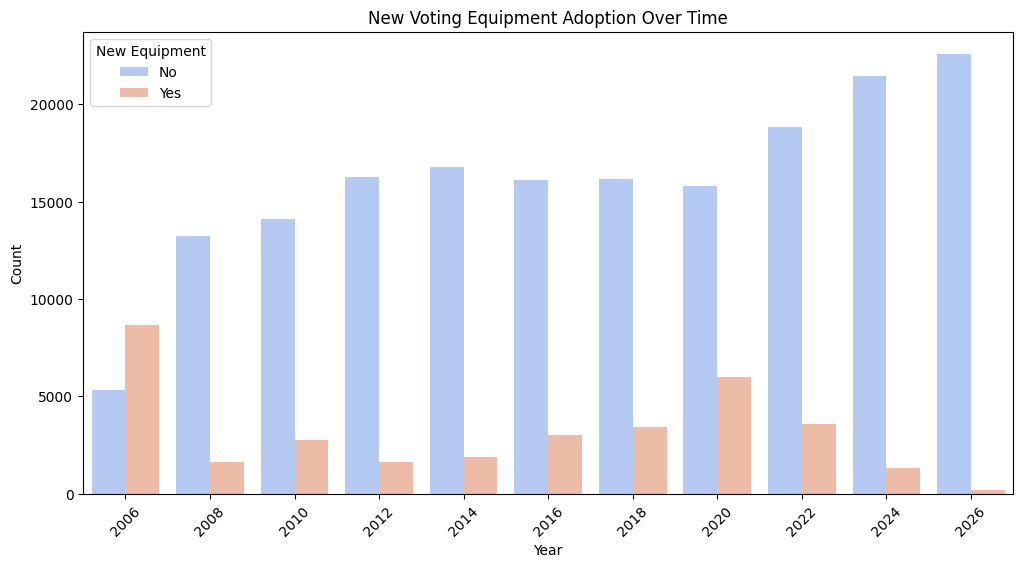

In [8]:

# Plot the number of new equipment instances over time
plt.figure(figsize=(12, 6))
sns.countplot(x='Year', hue='New Equipment', data=df.dropna(subset=['New Equipment']), palette='coolwarm')
plt.title('New Voting Equipment Adoption Over Time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='New Equipment', labels=['No', 'Yes'])
plt.xticks(rotation=45)
plt.show()

# todo: make this for each of the equipment types

In [9]:
df['New Equipment']

0          True
1         False
2          <NA>
3          True
4         False
          ...  
279745    False
279746     <NA>
279747    False
279748    False
279749     <NA>
Name: New Equipment, Length: 279750, dtype: object

/var/folders/4t/gs7xjwb92bd6lfy7w82b3s4r0000gn/T/ipykernel_89156/2589499017.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Equipment Type', bbox_to_anchor=(1.05, 1), loc='upper left')


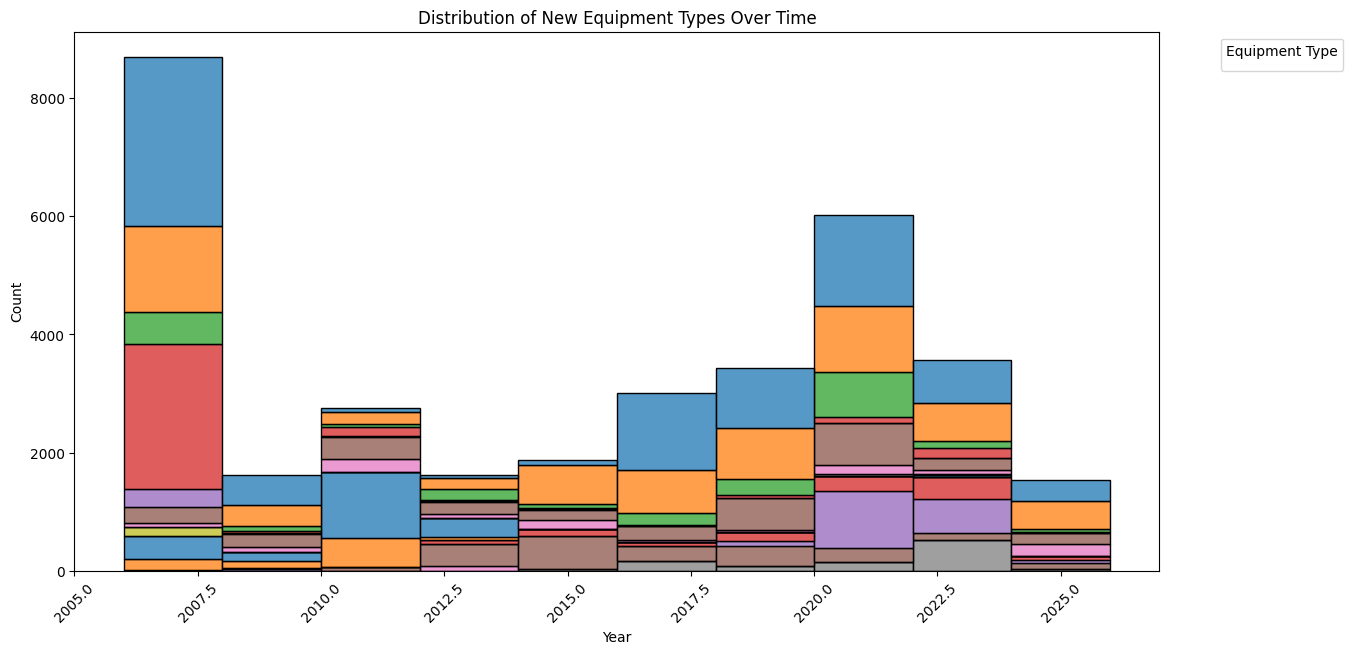

In [10]:
# Plot new equipment trends by Equipment Type
plt.figure(figsize=(14, 7))
sns.histplot(data=df[df['New Equipment']==True], x='Year', hue='Equipment Type', multiple='stack', palette='tab10', bins=10)
plt.title('Distribution of New Equipment Types Over Time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Equipment Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# todo: make legend, improve x-axis by year

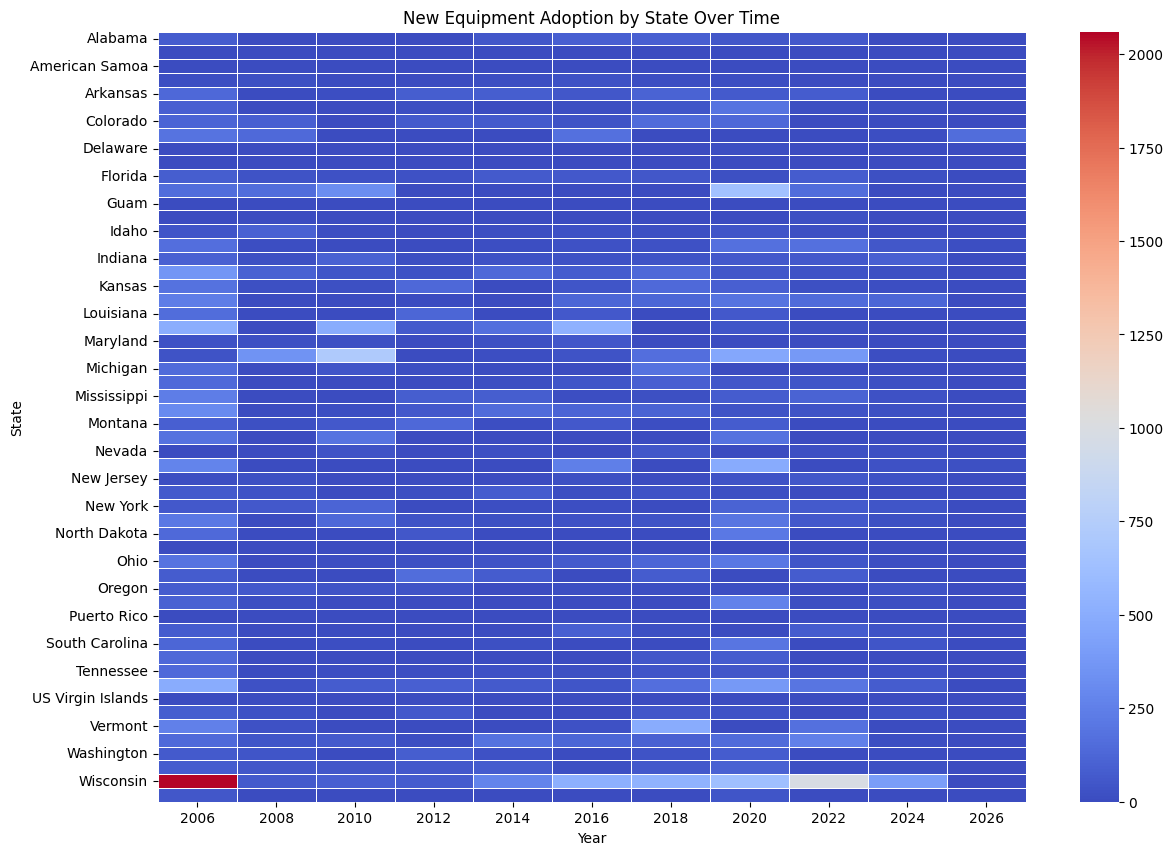

In [11]:

df['is_new'] = df['New Equipment']==True # this is prob not necessary
# Summary stats
distribution_by_state = df.groupby(['State', 'Year'])['is_new'].sum().reset_index()
distribution_by_state_pivot = distribution_by_state.pivot(index='State', columns='Year', values='is_new').fillna(0)

# Heatmap of new equipment adoption by state
plt.figure(figsize=(14, 10))
sns.heatmap(distribution_by_state_pivot, cmap='coolwarm', linewidths=0.5)
plt.title('New Equipment Adoption by State Over Time')
plt.xlabel('Year')
plt.ylabel('State')
plt.show()

# Display summary of new equipment per year
# print(df_filtered.groupby('Year')['New Equipment'].sum())

# todo: think about if something like this is useful at all

In [13]:
# NON VOTING EQUIPMENT TO EXCLUDE/SEPERATE FROM ANALYSIS
non_voting_equipment = ['Paper Poll Book',
                        'Hand Counted Paper Ballots', 
                        'Commercial Electronic Poll Book',
                        'In-House Electronic Poll Book',
                        'Data Unavailable']

all_equipment = df
voting_df = df[~df['Equipment Type'].isin(non_voting_equipment)]
non_voting_df = df[df['Equipment Type'].isin(non_voting_equipment)]

# OTHER EQUIPMENT TYPES DEEMED ACCEPTABLE
voting_equipment_types = ['Ballot Marking Device', 
                            'Hand-Fed Optical Scanner',
                            'Batch-Fed Optical Scanner',
                            'DRE-Touchscreen',
                            'Internet Voting: Fax',
                            'DRE-Push Button',
                            'DRE-Dial',
                            'Mechanical Lever Machine',
                            'Punch Card Voting System',
                            'Hybrid BMD/Tabulator',
                            'Internet Voting: Email',
                            'Internet Voting: Web Portal',
                            'Remote Ballot Marking System: Client-Side',
                            'Remote Ballot Marking System: Server-Side',
                            'Hybrid Optical Scan/DRE',
                            'Hybrid Optical Scan/BMD']

In [14]:
print("Non voting equipment\n",non_voting_df["Years in Use"].describe(),"\n")
print("Voting equipment\n",voting_df["Years in Use"].describe())

Non voting equipment
 count     17454.0
mean     4.548184
std      4.325197
min           0.0
25%           2.0
50%           4.0
75%           6.0
max          20.0
Name: Years in Use, dtype: Float64 

Voting equipment
 count    193254.0
mean     7.309603
std      6.623412
min           0.0
25%           2.0
50%           6.0
75%          10.0
max          54.0
Name: Years in Use, dtype: Float64


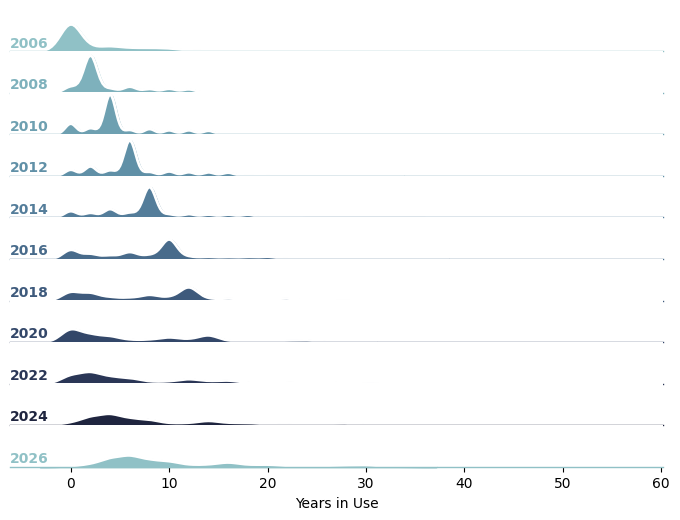

In [15]:
# using sample seaborn code https://seaborn.pydata.org/examples/kde_ridgeplot

pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(voting_df, row="Year", hue="Year", aspect=15, height=.5, palette=pal)

bw_adjust = 1 # smoothing

g.map(sns.kdeplot, "Years in Use",
      bw_adjust=bw_adjust, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Years in Use", clip_on=False, color="w", lw=2, bw_adjust=bw_adjust)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=1, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
      ax = plt.gca()
      ax.text(0, .2, label, fontweight="bold", color=color,
                  ha="left", va="center", transform=ax.transAxes)

g.map(label, "Years in Use")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.01)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

## Average Years in Use by Voting Equipment Type

In [32]:
replacement_by_type = {}

# Calculate the average years in use and standard deviation for each equipment type
for equipment in voting_equipment_types:
    subset = voting_df[(voting_df['Equipment Type'] == equipment) & (voting_df['Year']==2026)]['Years in Use']
    if not subset.empty:
        replacement_by_type[equipment] = {
            "Avg Years in Use": subset.mean(),
            "Std Dev": subset.std(),
            "N": len(subset)
        }
# Convert dictionary to DataFrame for plotting
replacement_df = pd.DataFrame.from_dict(replacement_by_type, orient='index').reset_index()
replacement_df.rename(columns={"index": "Equipment Type", "mean_years": "Avg Years in Use", "std_dev": "Std Dev", "n": "N"}, inplace=True)

# Sort by average years in use for better visualization
replacement_df = replacement_df.sort_values(by="Avg Years in Use", ascending=False)


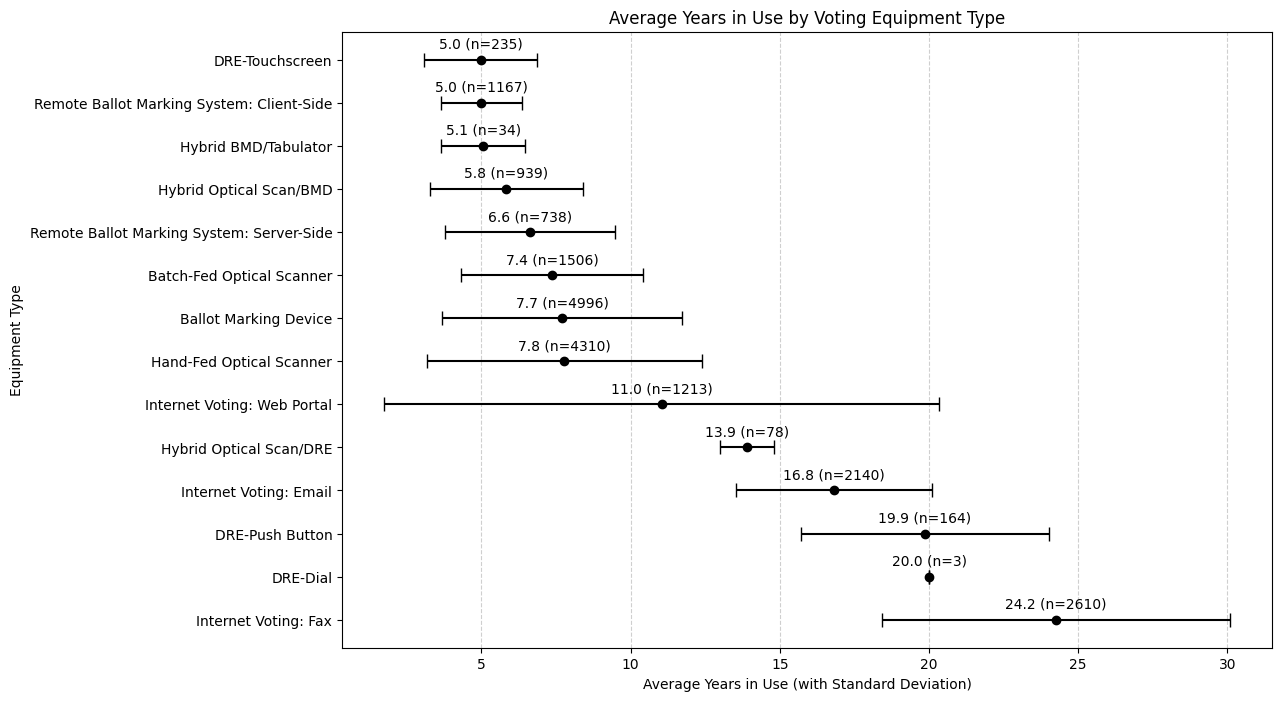

In [34]:
# Set figure size
plt.figure(figsize=(12, 8))

# Plot each point with error bars for standard deviation
plt.errorbar(
    replacement_df["Avg Years in Use"], 
    replacement_df["Equipment Type"], 
    xerr=replacement_df["Std Dev"], 
    fmt="o", color="black", capsize=5, markersize=6
)
# Add data labels slightly above each dot
for i, (avg, std, n) in enumerate(zip(replacement_df["Avg Years in Use"], replacement_df["Std Dev"], replacement_df["N"])):
    plt.text(avg, i + 0.2, f"{avg:.1f} (n={n})", ha='center', va='bottom', fontsize=10, color="black")


# Formatting
plt.title("Average Years in Use by Voting Equipment Type")
plt.xlabel("Average Years in Use (with Standard Deviation)")
plt.ylabel("Equipment Type")
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Show plot
plt.show()

## Peak Detection / Measurement

Started messing around with identifying peaks for each year, and measuring their area. My goal was to be able to select the two-three largest peaks and then measure the time between them.

Used chatgpt and drew a little from [this method](https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data), which is for timeseries data so not right for this. 

In [112]:
years = voting_df["Year"].unique()

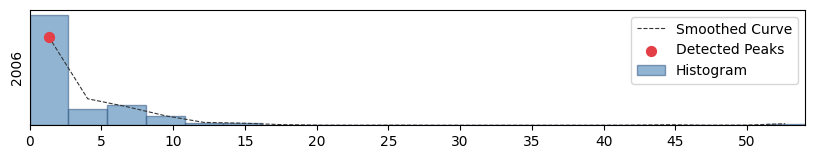

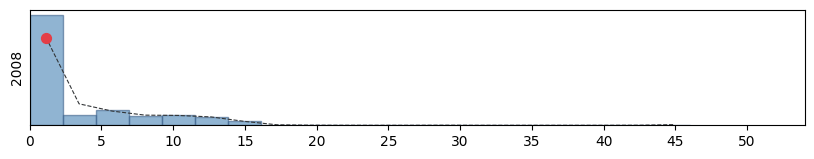

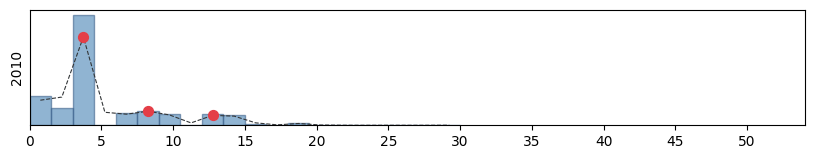

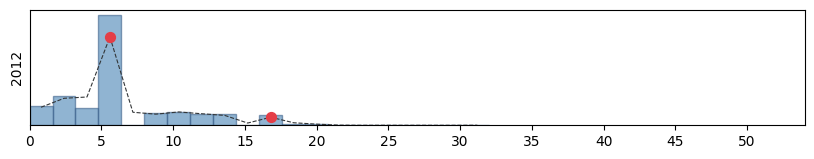

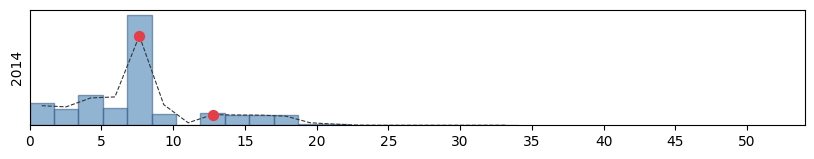

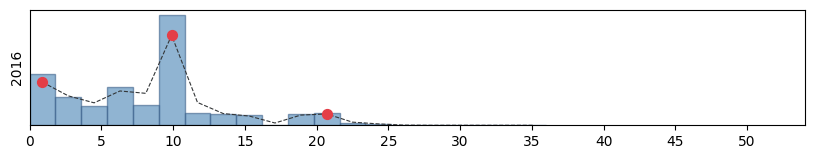

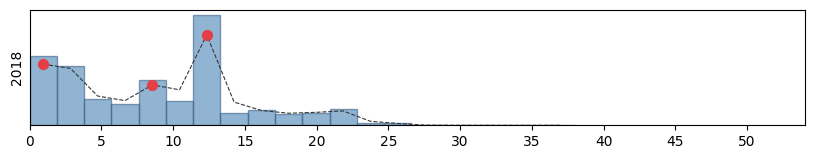

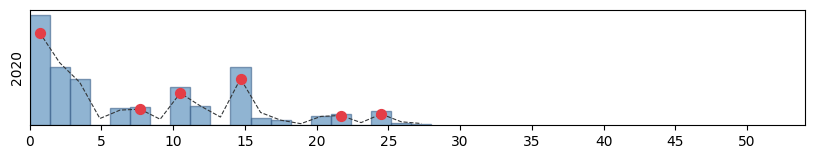

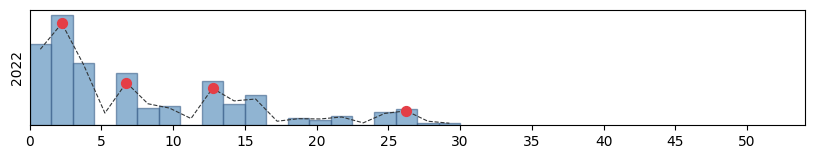

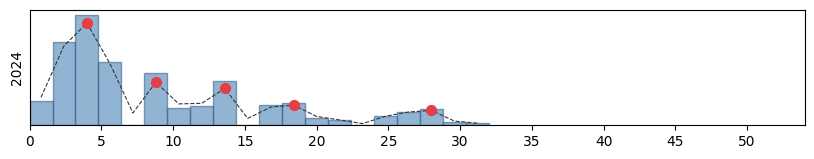

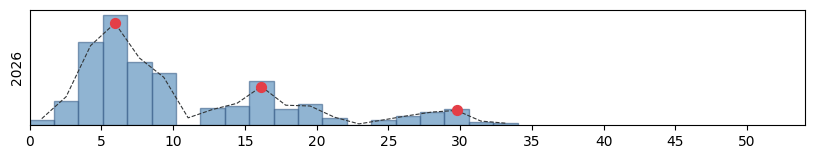

In [94]:
# Peak detection with smoothing and padding
def get_smoothed_peaks(hist_vals, bin_centers, sigma=0.5, prominence=200, distance=2):
    hist_vals_padded = np.insert(hist_vals, 0, 0)  # Add 0 at beginning to capture first peak
    smoothed_vals = gaussian_filter1d(hist_vals_padded, sigma=sigma)  # Apply Gaussian smoothing
    peak_indices, properties = scipy.signal.find_peaks(smoothed_vals, prominence=prominence, distance=distance)
    peak_indices = peak_indices[peak_indices > 0] - 1  # Adjust indices after padding
    return peak_indices, smoothed_vals[1:], properties["prominences"]  # Remove padding from smoothed values

# DataFrame to store peak values and heights
peak_data = []

# Get global x-axis limits
global_xmin, global_xmax = voting_df["Years in Use"].min(), voting_df["Years in Use"].max()

for year in years:
    y = np.array(voting_df[voting_df["Year"] == year]["Years in Use"])
    y = y[~np.isnan(y)]
    

    # Compute histogram
    hist_vals, bin_edges = np.histogram(y, bins=20, density=False)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Get bin centers

    # Use modified peak detection with smoothing
    peak_indices, smoothed_vals, peak_heights = get_smoothed_peaks(hist_vals, bin_centers)

    # Store detected peaks in DataFrame
    for i, peak in enumerate(bin_centers[peak_indices]):
        peak_data.append({"Year": year, "Peak Value": peak, "Peak Height": peak_heights[i]})

    # Plot histogram
    plt.figure(figsize=(10, 1.5))
    plt.bar(bin_centers, hist_vals, width=np.diff(bin_edges), alpha=0.6, color="steelblue", label="Histogram",edgecolor=blue)

    # Overlay smoothed line
    plt.plot(bin_centers, smoothed_vals, color=bpc_darkgray, linestyle="dashed", label="Smoothed Curve",linewidth=.8)

    # Overlay detected peaks
    plt.scatter(bin_centers[peak_indices], smoothed_vals[peak_indices], color=red, label="Detected Peaks", s=50, zorder=3)

    # Formatting
    plt.xlim(global_xmin, global_xmax)  # Ensure consistent x-axis limits
    plt.xticks(np.arange(global_xmin, global_xmax + 1, step=5))  # Adjust step size if needed
    plt.yticks([])  # Remove y-axis labels
    plt.ylabel(f"{year}")

    if year == min(years):
        plt.legend()

    plt.savefig(f"figs/{year}.png",bbox_inches='tight')
    plt.show()

# Convert detected peak data to DataFrame
peak_df = pd.DataFrame(peak_data)

In [95]:
from PIL import Image

def create_gif(image_paths, output_path, duration=200):

    frames = [Image.open(image_path) for image_path in image_paths]
    
    # Ensure all frames have the same palette or convert them
    first_frame = frames[0]
    if all(frame.mode != 'P' for frame in frames):
        first_frame.save(output_path, save_all=True, append_images=frames[1:], duration=duration, loop=0)
    else:
        first_frame.save(output_path, save_all=True, append_images=frames[1:], duration=duration, loop=0)

if __name__ == "__main__":
    image_paths = [f"figs/{year}.png" for year in years]
    output_gif_path = "figs/animation.gif"
    create_gif(image_paths, output_gif_path)

In [ ]:
peak_df.sort_values(by=["Year","Peak Height"],inplace=True,ascending=False)
peak_diffs = []
years_peaks = []

for year in years:
    if len(peak_df[peak_df["Year"]==year]) > 1: # if more than 1 peak
        # get difference between top two peaks, store to list
        peak_diffs += [abs(peak_df[peak_df["Year"]==year]["Peak Value"].iloc[0] - peak_df[peak_df["Year"]==year]["Peak Value"].iloc[1])]
        # store relevant year to list
        years_peaks += [year]
    
peak_diffs_df = pd.DataFrame(peak_diffs,index=years_peaks,columns = ["Difference (abs) between two highest peaks"])

display(peak_diffs_df)
peak_diffs_df.describe()

avg_peak_diff = peak_diffs_df["Difference (abs) between two highest peaks"].mean()

,Difference (abs) between two highest peaks
2010,9.0
2012,11.2
2014,5.1
2016,9.0
2018,11.4
2020,14.0
2022,4.5
2024,4.8
2026,10.2


np.float64(8.8)

In [97]:
# was curious why peak seemed to stay the same 2006 - 2008
# voting_df[voting_df["Year"]=="2006"]["Years in Use"].describe()
# voting_df[voting_df["Year"]=="2008"]["Years in Use"].describe()

## Some descriptives for report outlining

Average equipment age by state

In [101]:
voting_df_26 = voting_df[voting_df["Year"]==2026]

In [102]:
state_eq_len = pd.DataFrame(voting_df_26.groupby(["State"])["Years in Use"].mean())
state_eq_len.sort_values(["Years in Use"],inplace=True,ascending=False)
display(state_eq_len.head(5))
display(state_eq_len.tail(5))

,Years in Use
State,
Maine,17.231278
Texas,15.950864
New Mexico,15.907407
Louisiana,15.177083
Indiana,14.725367


,Years in Use
State,
Pennsylvania,5.907336
Georgia,5.5
Kentucky,5.076923
Connecticut,5.044248
Illinois,4.801187


In [114]:
print("Percent of states and territories whose average equipment age exceed 8.8 years.")
print(len(state_eq_len[state_eq_len["Years in Use"]>avg_peak_diff])/len(state_eq_len))

Percent of states and territories whose average equipment age exceed 8.8 years.
0.6545454545454545


Age of equipment over time

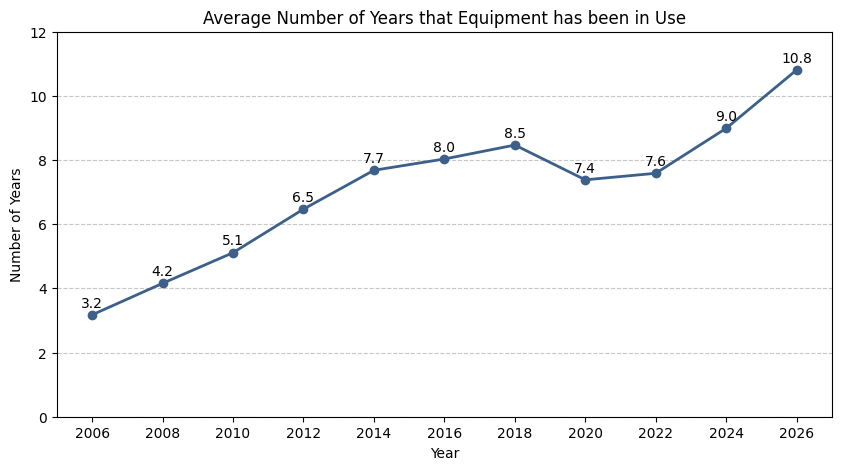

In [109]:
years_in_use = voting_df.groupby(["Year"])["Years in Use"].mean().reset_index()

# Ensure "Year" is treated as numeric
years_in_use["Year"] = years_in_use["Year"].astype(int)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(years_in_use["Year"], years_in_use["Years in Use"], marker="o", linestyle="-", color=blue, linewidth=2)

# Add data labels
for i, value in enumerate(years_in_use["Years in Use"]):
    ax.text(years_in_use["Year"][i], value+.15, f"{value:.1f}", ha="center", va="bottom", fontsize=10, color="black")

# Formatting
ax.set_ylabel("Number of Years", fontsize=10)
ax.set_xlabel("Year", fontsize=10)
ax.set_title("Average Number of Years that Equipment has been in Use", fontsize=12)
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Ensure x-axis ticks are formatted correctly
plt.xticks(years_in_use["Year"], rotation=0, ha="center")

plt.ylim(0, 12)

plt.show()

When new voting equipment infusions happen

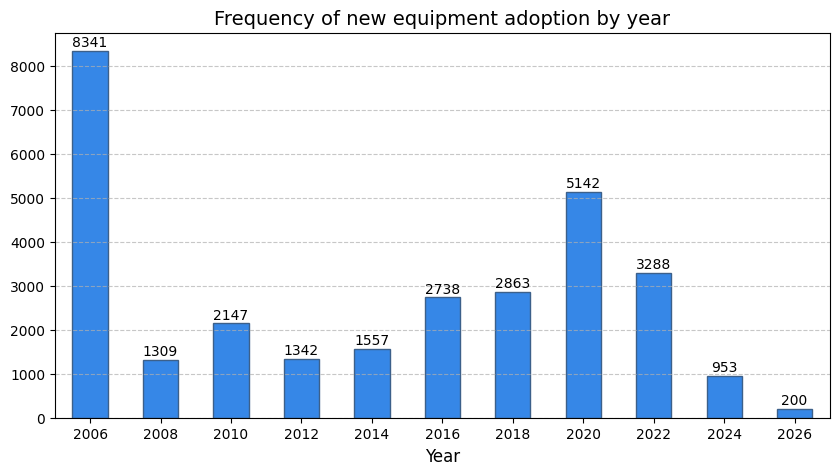

In [110]:
new_equipment_counts = voting_df.groupby("Year")["New Equipment"].sum()

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
new_equipment_counts.plot(kind="bar", color=lightblue, edgecolor=blue, ax=ax)

# Formatting
ax.set_xlabel("Year", fontsize=12)
ax.set_title("Frequency of new equipment adoption by year", fontsize=14)
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Add data labels
for i, value in enumerate(new_equipment_counts):
    ax.text(i, value + 100, str(value), ha="center", fontsize=10)


# Rotate x-axis labels for better visibility
plt.xticks(rotation=0, ha="center")

plt.show()

this chart is bad, trying to establish some relationship between funding and eq upgrades

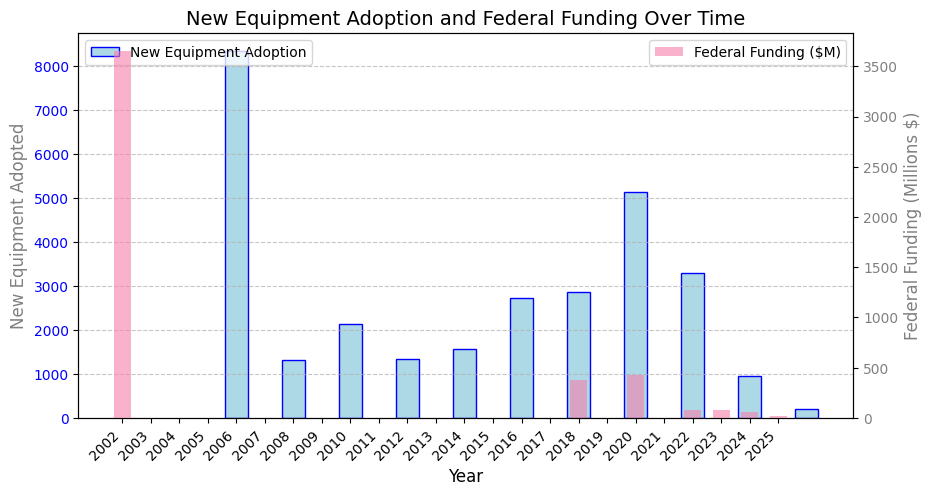

In [111]:
year_enacted = [2002, 2018, 2020, 2020, 2022, 2023, 2024, 2025]
federal_funding_millions = [3650, 380, 400, 425, 75, 75, 55, 15]

# Compute new equipment counts per year
new_equipment_counts = voting_df.groupby("Year")["New Equipment"].sum()

# Convert index to integers for consistent plotting
new_equipment_counts.index = new_equipment_counts.index.astype(int)

# Ensure all years are included in the x-axis range
all_years = np.arange(min(year_enacted), max(year_enacted) + 1)

# Align federal funding with years
funding_dict = dict(zip(year_enacted, federal_funding_millions))
funding_values = [funding_dict.get(year, 0) for year in all_years]  # Fill missing years with 0

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Primary y-axis (New Equipment Adoption)
ax1.bar(new_equipment_counts.index, new_equipment_counts, color="lightblue", edgecolor="blue", label="New Equipment Adoption")
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("New Equipment Adopted", fontsize=12, color="grey")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.grid(axis="y", linestyle="--", alpha=0.7)

# Secondary y-axis (Federal Funding)
ax2 = ax1.twinx()
ax2.bar(all_years, funding_values, color=pink, alpha=0.6, label="Federal Funding ($M)", width=0.6)
ax2.set_ylabel("Federal Funding (Millions $)", fontsize=12, color="gray")
ax2.tick_params(axis="y", labelcolor="gray")

# Set x-axis to show all years
ax1.set_xticks(all_years)
ax1.set_xticklabels(all_years, rotation=45, ha="right")

# Titles & Legends
ax1.set_title("New Equipment Adoption and Federal Funding Over Time", fontsize=14)
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()